In [1]:
import pandas as pd

In [2]:
#load data
# segment = 'NTC'
# X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')

In [3]:
#jied
def xgbc_model_builder3(n_estimators = 100,
                          max_depth = 6,
                          learning_rate=0.3,
                          subsample = 1,
                          colsample_bytree = 1,
                          colsample_bylevel = 1,
                          min_child_weight =1,
                          gamma = 0,
                          reg_alpha = 0,
                          reg_lambda = 1,
                          eta = 0.3,
                       random_state = 42):
    
    import xgboost as xgb
    model = xgb.XGBClassifier(n_estimators = n_estimators,
                              max_depth = max_depth,
                              learning_rate=learning_rate,
                              subsample = subsample,
                              colsample_bytree = colsample_bytree,
                              colsample_bylevel = colsample_bylevel,
                              min_child_weight =min_child_weight,
                              gamma = gamma,
                              reg_alpha = reg_alpha,
                              reg_lambda = reg_lambda,
                              eta = eta,
                              random_state = 42,
                              enable_categorical=True,
                              n_jobs = -1,
                              objective = "binary:logistic")
    return model

In [4]:
def XGBC_ohe_model_auc(cleaned_df, xgbc_model, segment):
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.metrics import mean_absolute_error
    import pandas as pd
    import numpy as np
    from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
    from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
    from catboost.utils import get_confusion_matrix, get_roc_curve, get_fnr_curve, get_fpr_curve
    from sklearn.metrics import RocCurveDisplay
    from sklearn import metrics
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    y = 'D3_within12months'
    X = cleaned_df.drop(columns = [y, 'loan_account_no'])
    y = cleaned_df[y]
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 11, train_size = 0.8,
                                                        test_size = 0.2, stratify = y)

    object_columns = X.select_dtypes(include=['object','category']).columns

    from sklearn.preprocessing import OneHotEncoder
    
    ohe = OneHotEncoder(sparse_output = False,drop='first').set_output(transform='pandas')
    
    one_hot_encoded_object_X_train = ohe.fit_transform(X_train[object_columns])
    one_hot_encoded_object_X_test = ohe.transform(X_test[object_columns])
    
    final_X_train = pd.concat([one_hot_encoded_object_X_train, X_train.select_dtypes('number')], axis=1)
    final_X_test = pd.concat([one_hot_encoded_object_X_test, X_test.select_dtypes('number')], axis=1)

    X_train = final_X_train
    X_test = final_X_test

    model = xgbc_model

    model.fit(X_train, y_train,
                   eval_set = [(X_test, y_test)])

    y_pred_proba = model.predict_proba(X_test)[:,1]

    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred_proba)
    
    #compute optimal threshold based on roc_auc curve only
    opt = true_positive_rate - false_positive_rate
    tp_fp_diff = pd.DataFrame({'thresholds': threshold, 'tpr_fpr': opt})

    max_index = tp_fp_diff.tpr_fpr.argmax()
    THRESHOLD = tp_fp_diff.iloc[max_index][0]
    
    y_pred = np.where(y_pred_proba > THRESHOLD, 1, 0)

    plt.subplots(1, figsize = (5,5))
    luh = roc_auc_score(y_test, y_pred_proba)
    plt.title(f'ROC_AUC Curve: {luh:.2f}')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0,1], ls = "--")
    plt.plot([0,0],[1,0], c= ".7"), plt.plot([1,1], c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    print(classification_report(y_test, y_pred, target_names = ['Good Customer','Bad Customer']))
    cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(cnf_matrix)
    print(tn, fp, fn, tp)

    booster = model.get_booster()
    
    sns.distplot(y_pred_proba)
    plt.show()

    feat_importances = model.feature_importances_
    feature_names = booster.feature_names

    feat_imp_df = pd.DataFrame({
        'variable':feature_names,
        'feature_importances':feat_importances
    })
    
    feat_imp_df.to_csv(f'./Feature_Importance/featimportance_XGB_{segment}.csv', index=False)

    feat_imp_df = feat_imp_df.sort_values(by='feature_importances', ascending=False)
    print(feat_imp_df[:20])

[0]	validation_0-logloss:0.30808
[1]	validation_0-logloss:0.30001
[2]	validation_0-logloss:0.29508
[3]	validation_0-logloss:0.29141
[4]	validation_0-logloss:0.28877
[5]	validation_0-logloss:0.28719
[6]	validation_0-logloss:0.28584
[7]	validation_0-logloss:0.28476
[8]	validation_0-logloss:0.28387
[9]	validation_0-logloss:0.28297
[10]	validation_0-logloss:0.28227
[11]	validation_0-logloss:0.28186
[12]	validation_0-logloss:0.28166
[13]	validation_0-logloss:0.28146
[14]	validation_0-logloss:0.28122
[15]	validation_0-logloss:0.28115
[16]	validation_0-logloss:0.28102
[17]	validation_0-logloss:0.28061
[18]	validation_0-logloss:0.28007
[19]	validation_0-logloss:0.28003
[20]	validation_0-logloss:0.28041
[21]	validation_0-logloss:0.28022
[22]	validation_0-logloss:0.28015
[23]	validation_0-logloss:0.27983
[24]	validation_0-logloss:0.27963
[25]	validation_0-logloss:0.27925
[26]	validation_0-logloss:0.27910
[27]	validation_0-logloss:0.27901
[28]	validation_0-logloss:0.27897
[29]	validation_0-loglos

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_14744\2970468033.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


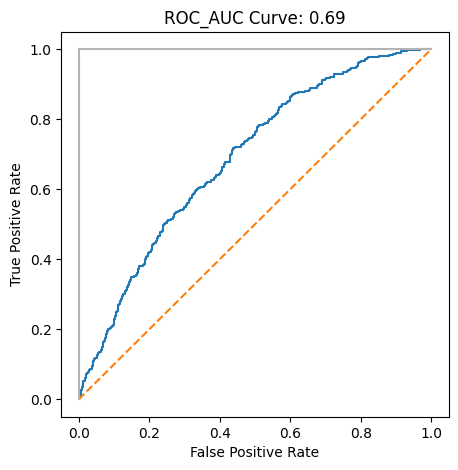

               precision    recall  f1-score   support

Good Customer       0.95      0.56      0.71      3336
 Bad Customer       0.14      0.72      0.23       320

     accuracy                           0.58      3656
    macro avg       0.54      0.64      0.47      3656
 weighted avg       0.88      0.58      0.67      3656

[[1875 1461]
 [  91  229]]
1875 1461 91 229


C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_14744\2970468033.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


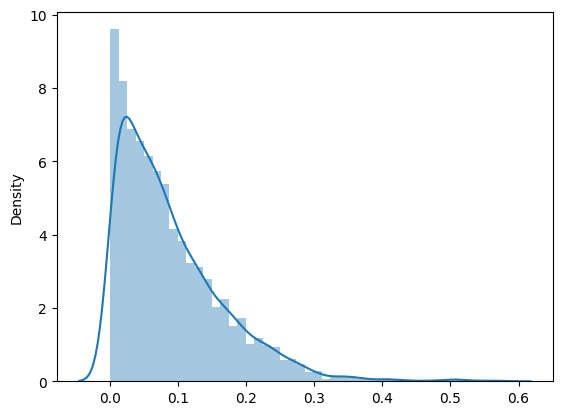

                                          variable  feature_importances
38                       res_state_grp_MAHARASHTRA             0.115407
47                          number_of_installments             0.092429
17                               branch_grp_OTHERS             0.053303
21                                branch_grp_VIRAR             0.036108
12                           industry_grp_APPARELS             0.036078
25                          asset_model_grp_AVENIS             0.032116
34                             res_city_grp_MUMBAI             0.031643
14                            branch_grp_GHAZIABAD             0.026967
23                           branch_grp_WEST_DELHI             0.025239
41                  res_resident_status_grp_RENTED             0.023635
52                                        dp_ratio             0.022852
44                             down_payment_amount             0.022329
0   occupation_type_SELF_EMPLOYED_NON_PROFESSIONAL             0

In [5]:
xgbc_ntc_v3 = xgbc_model_builder3(n_estimators = 395,
                          max_depth = 2,
                          learning_rate=0.28267052670545584,
                          subsample =  0.8736932106048627,
                          colsample_bytree = 0.8721230154351118,
                          colsample_bylevel = 0.9299702033681603,
                          min_child_weight =9,
                          gamma = 0.19897441739799793,
                          reg_alpha = 4,
                          reg_lambda = 1,
                          eta = 0.1000998503939086,
                          random_state = 42)

segment = 'NTC'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
XGBC_ohe_model_auc(X, xgbc_ntc_v3, segment)

[0]	validation_0-logloss:0.31721
[1]	validation_0-logloss:0.31178
[2]	validation_0-logloss:0.30761
[3]	validation_0-logloss:0.30285
[4]	validation_0-logloss:0.30019
[5]	validation_0-logloss:0.29840
[6]	validation_0-logloss:0.29788
[7]	validation_0-logloss:0.29644
[8]	validation_0-logloss:0.29649
[9]	validation_0-logloss:0.29634
[10]	validation_0-logloss:0.29583
[11]	validation_0-logloss:0.29582
[12]	validation_0-logloss:0.29467
[13]	validation_0-logloss:0.29429
[14]	validation_0-logloss:0.29429
[15]	validation_0-logloss:0.29428
[16]	validation_0-logloss:0.29428
[17]	validation_0-logloss:0.29459
[18]	validation_0-logloss:0.29459
[19]	validation_0-logloss:0.29458
[20]	validation_0-logloss:0.29459
[21]	validation_0-logloss:0.29459
[22]	validation_0-logloss:0.29454
[23]	validation_0-logloss:0.29454
[24]	validation_0-logloss:0.29454
[25]	validation_0-logloss:0.29454
[26]	validation_0-logloss:0.29454
[27]	validation_0-logloss:0.29454
[28]	validation_0-logloss:0.29454
[29]	validation_0-loglos

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_14744\2970468033.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


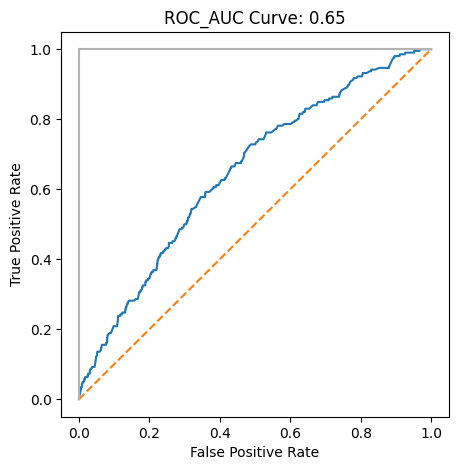

               precision    recall  f1-score   support

Good Customer       0.95      0.52      0.67      2068
 Bad Customer       0.13      0.72      0.22       206

     accuracy                           0.54      2274
    macro avg       0.54      0.62      0.44      2274
 weighted avg       0.88      0.54      0.63      2274

[[1068 1000]
 [  57  149]]
1068 1000 57 149


C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_14744\2970468033.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


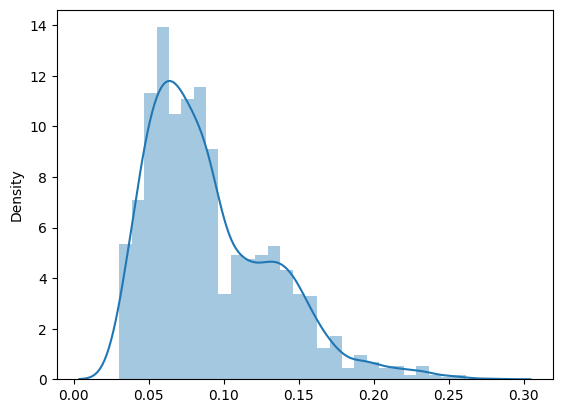

                          variable  feature_importances
17               branch_grp_OTHERS             0.112984
48                 loan_asset_cost             0.108687
47          number_of_installments             0.104197
9          manufacturer_grp_SUZUKI             0.097242
45                    total_income             0.090066
44             down_payment_amount             0.088109
43                             age             0.086424
38       res_state_grp_MAHARASHTRA             0.085216
52                        dp_ratio             0.083604
34             res_city_grp_MUMBAI             0.072868
30          asset_model_grp_OTHERS             0.070603
33          res_city_grp_GHAZIABAD             0.000000
32              res_city_grp_DELHI             0.000000
31        asset_model_grp_SPLENDOR             0.000000
35             res_city_grp_OTHERS             0.000000
36              res_city_grp_THANE             0.000000
37         res_state_grp_KARNATAKA             0

In [6]:
xgbc_low_CIBIL_v3 = xgbc_model_builder3(n_estimators = 317,
                          max_depth = 9,
                          learning_rate=0.27449790266313423,
                          subsample =  0.6254233401144095,
                          colsample_bytree = 0.8423839899124046,
                          colsample_bylevel = 0.8950877702656028,
                          min_child_weight =72,
                          gamma = 9.766155382529167,
                          reg_alpha = 1,
                          reg_lambda = 32,
                          eta = 0.19526017570266982,
                          random_state = 42)

segment = 'low_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
XGBC_ohe_model_auc(X, xgbc_low_CIBIL_v3, segment)

[0]	validation_0-logloss:0.24576
[1]	validation_0-logloss:0.23581
[2]	validation_0-logloss:0.22981
[3]	validation_0-logloss:0.22512
[4]	validation_0-logloss:0.22319
[5]	validation_0-logloss:0.22111
[6]	validation_0-logloss:0.21956
[7]	validation_0-logloss:0.21937
[8]	validation_0-logloss:0.21870
[9]	validation_0-logloss:0.21851
[10]	validation_0-logloss:0.21812
[11]	validation_0-logloss:0.21781
[12]	validation_0-logloss:0.21763
[13]	validation_0-logloss:0.21800
[14]	validation_0-logloss:0.21788
[15]	validation_0-logloss:0.21762
[16]	validation_0-logloss:0.21741
[17]	validation_0-logloss:0.21739
[18]	validation_0-logloss:0.21762
[19]	validation_0-logloss:0.21761
[20]	validation_0-logloss:0.21790
[21]	validation_0-logloss:0.21790
[22]	validation_0-logloss:0.21745
[23]	validation_0-logloss:0.21726
[24]	validation_0-logloss:0.21719
[25]	validation_0-logloss:0.21724
[26]	validation_0-logloss:0.21698
[27]	validation_0-logloss:0.21736
[28]	validation_0-logloss:0.21735
[29]	validation_0-loglos

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_14744\2970468033.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


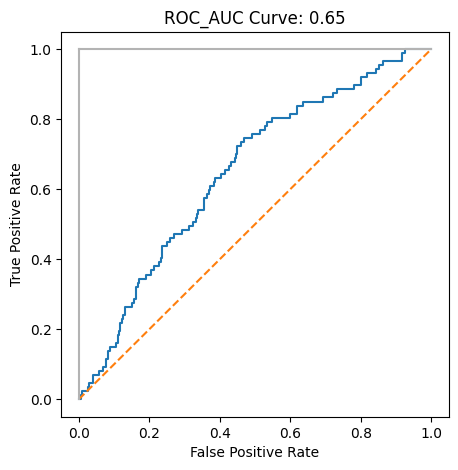

               precision    recall  f1-score   support

Good Customer       0.97      0.53      0.69      1398
 Bad Customer       0.09      0.74      0.16        87

     accuracy                           0.54      1485
    macro avg       0.53      0.63      0.42      1485
 weighted avg       0.92      0.54      0.66      1485

[[743 655]
 [ 23  64]]
743 655 23 64


C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_14744\2970468033.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


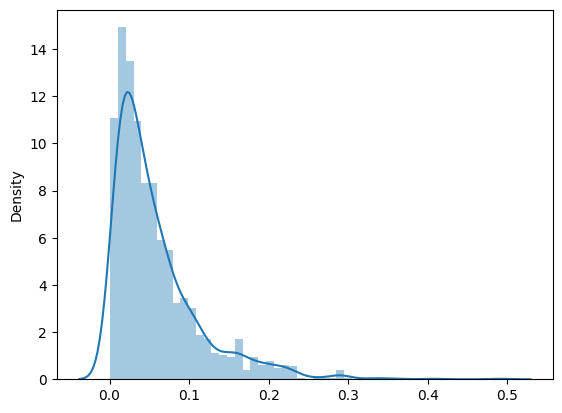

                                          variable  feature_importances
37                         res_state_grp_KARNATAKA             0.076412
41                  res_resident_status_grp_RENTED             0.051232
38                       res_state_grp_MAHARASHTRA             0.044840
3                           marital_status_MARRIED             0.034868
36                              res_city_grp_THANE             0.034515
18                      branch_grp_SOUTH_BANGALORE             0.033149
6                      nature_of_business_SERVICES             0.032932
47                          number_of_installments             0.030918
52                                        dp_ratio             0.028665
30                          asset_model_grp_OTHERS             0.028414
26                         asset_model_grp_BURGMAN             0.026582
46                                   interest_rate             0.025591
44                             down_payment_amount             0

In [7]:
xgbc_mid_CIBIL_v3 = xgbc_model_builder3(n_estimators = 395,
                          max_depth = 2,
                          learning_rate=0.28267052670545584,
                          subsample =  0.8736932106048627,
                          colsample_bytree = 0.8721230154351118,
                          colsample_bylevel = 0.9299702033681603,
                          min_child_weight =9,
                          gamma = 0.19897441739799793,
                          reg_alpha = 4,
                          reg_lambda = 1,
                          eta = 0.1000998503939086,
                          random_state = 42)

segment = 'mid_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
XGBC_ohe_model_auc(X, xgbc_mid_CIBIL_v3, segment)

[0]	validation_0-logloss:0.17487
[1]	validation_0-logloss:0.15934
[2]	validation_0-logloss:0.14882
[3]	validation_0-logloss:0.14196
[4]	validation_0-logloss:0.13668
[5]	validation_0-logloss:0.13329
[6]	validation_0-logloss:0.13162
[7]	validation_0-logloss:0.12976
[8]	validation_0-logloss:0.12841
[9]	validation_0-logloss:0.12756
[10]	validation_0-logloss:0.12680
[11]	validation_0-logloss:0.12588
[12]	validation_0-logloss:0.12563
[13]	validation_0-logloss:0.12514
[14]	validation_0-logloss:0.12499
[15]	validation_0-logloss:0.12450
[16]	validation_0-logloss:0.12442
[17]	validation_0-logloss:0.12435
[18]	validation_0-logloss:0.12443
[19]	validation_0-logloss:0.12433
[20]	validation_0-logloss:0.12399
[21]	validation_0-logloss:0.12384
[22]	validation_0-logloss:0.12367
[23]	validation_0-logloss:0.12357
[24]	validation_0-logloss:0.12357
[25]	validation_0-logloss:0.12358
[26]	validation_0-logloss:0.12356
[27]	validation_0-logloss:0.12374
[28]	validation_0-logloss:0.12367
[29]	validation_0-loglos

C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_19984\2970468033.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  THRESHOLD = tp_fp_diff.iloc[max_index][0]


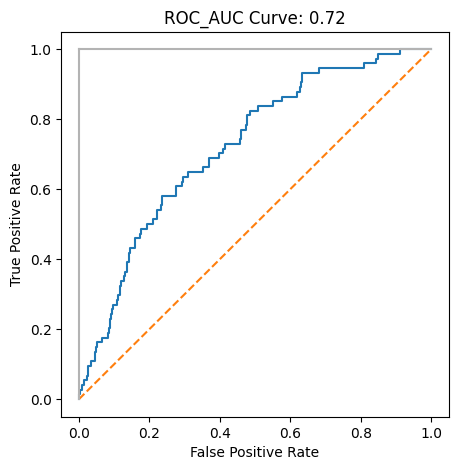

               precision    recall  f1-score   support

Good Customer       0.98      0.76      0.86      2448
 Bad Customer       0.07      0.57      0.12        74

     accuracy                           0.76      2522
    macro avg       0.53      0.67      0.49      2522
 weighted avg       0.96      0.76      0.84      2522

[[1869  579]
 [  32   42]]
1869 579 32 42


C:\Users\emanlangit.AEONCREDIT\AppData\Local\Temp\ipykernel_19984\2970468033.py:76: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_proba)


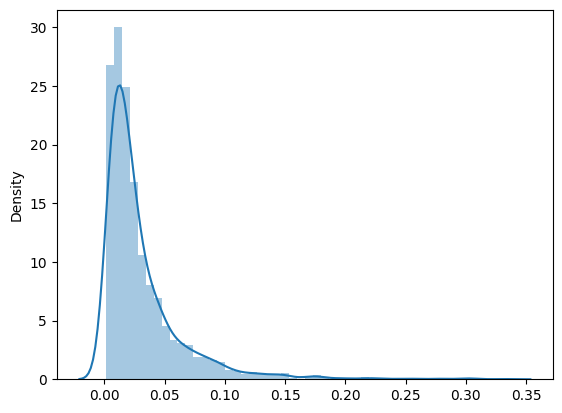

                                          variable  feature_importances
37                         res_state_grp_KARNATAKA             0.126125
38                       res_state_grp_MAHARASHTRA             0.083339
47                          number_of_installments             0.068658
41                  res_resident_status_grp_RENTED             0.066340
24                          asset_model_grp_ACTIVA             0.057955
52                                        dp_ratio             0.051770
46                                   interest_rate             0.051695
43                                             age             0.043001
2                                      gender_MALE             0.041132
7                           manufacturer_grp_HONDA             0.040714
44                             down_payment_amount             0.035023
42                       res_years_at_current_city             0.031881
49                    res_years_at_current_address             0

In [5]:
xgbc_high_CIBIL_v3 = xgbc_model_builder3(n_estimators = 409,
                          max_depth = 4,
                          learning_rate=0.27280612062363463,
                          subsample =  0.7700623497964979,
                          colsample_bytree = 0.6488152939379115,
                          colsample_bylevel = 0.7200762468698007,
                          min_child_weight =50,
                          gamma = 0.5158278167282759,
                          reg_alpha = 3,
                          reg_lambda = 1,
                          eta = 0.10903538202225403,
                          random_state = 42)

segment = 'high_CIBIL'
X = pd.read_csv(f'./Wrangled_Data/wrangled_{segment}.csv')
XGBC_ohe_model_auc(X, xgbc_high_CIBIL_v3, segment)